# Setup

In [1]:
!source activate /home/gilbee3/anaconda3/envs/akita

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white')
import os
import scikit_posthocs as sp
import pybedtools

In [3]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data.
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
#COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

In [4]:
DATA_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome/data'

## Formatting data for analysis
The results of this are written out to files that can be loaded for any downstream analysis to make starting up faster each time. 

In [5]:
COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
anc_list = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_hsmrca.txt")
anc_g, anc_m, anc_s = comp_data_setup(anc_list, 'hsmrca_ancestral')
anc_g = anc_g[anc_g.genome_avg_spearman!='']

NameError: name 'comp_data_setup' is not defined

In [ ]:
write_comp_dfs('anc', anc_g, anc_m, anc_s)

## Functions

In [6]:
def write_comp_dfs(base, g, m, s):
    g.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/%s_genomewide_averages.csv' % base)
    m.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/%s_window_mse.csv' % base)
    s.to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/%s_window_spearman.csv' % base)
    return

In [7]:
def comp_data_setup(list_file, base):
    comp_list=pd.read_table(list_file, sep=' ', names=['1KG','ancestor'])
    if base != 'hg38_reference':
        base_df = comp_list[comp_list.ancestor==base].set_index('1KG')
    else:
        base_df = comp_list.set_index('1KG')
    
    comp_dict = {}
    print('first for')
    for row in base_df.index:
        ind = str(base_df.loc[row].name)
        filename = '3dcomp_%s_vs_%s.txt' % (ind,base)
        if os.path.exists('%s/%s' % (COMP_PATH,filename)):
            try:
                df = pd.read_table('%s/%s' % (COMP_PATH,filename))
                df = df[df.chr != 'chrX']
                comp_dict[ind] = df
            except:
                continue     
    print('done')
    
    indivs = list(comp_dict.keys())
    df = comp_dict[list(comp_dict.keys())[0]].set_index(['chr','windowStartPos'])
    windows = df.index
    ### Window by window
    mse = pd.DataFrame(index = windows, columns = indivs)
    spear = pd.DataFrame(index = windows, columns = indivs)
    
    ### Genome wide averages        
    base_df['genome_avg_mse']=''
    base_df['genome_avg_spearman']=''
    print('second for')
    for ind in comp_dict.keys():
        df = comp_dict[ind]

        avg_mse =float(np.mean(df['mse']))
        avg_spearman = float(np.mean(df['spearman']))

        base_df.genome_avg_mse.loc[ind]=avg_mse
        base_df.genome_avg_spearman.loc[ind]=avg_spearman
        
        
        df = comp_dict[ind]
        df = df.set_index(['chr','windowStartPos'])
        mse[ind]=df['mse']
        spear[ind]=df['spearman']
    print('done')  
    

    
    base_df['temp'] = base_df.index
    new = base_df.temp.str.split("_", expand = True)
    base_df['super_pop'] = new[0]
    base_df['sub_pop'] = new[1]
    base_df['sex'] = new[2]
    base_df['id'] = new[3]
    
    genome_wide = base_df.drop(columns=['temp'])

    mse.columns = mse.columns.str.split('_', expand=True)
    spear.columns = spear.columns.str.split('_', expand=True)
    
    return genome_wide, mse, spear

In [8]:
def corr_plot(df):
    g = sns.lmplot(x='genome_avg_mse',y='divergence', hue='super_pop', data=df,scatter_kws={'s':2}, line_kws={'color': 'gray'},aspect=1.2)
    slope, intercept, r, p, se = stats.linregress(df['genome_avg_mse'].values, df['divergence'].values)
    _ = plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

In [9]:
def per_window_hists(mse, spear, div):
    mse_flat = mse.to_numpy().flatten()
    spear_flat = spear.to_numpy().flatten()
    div_flat = div.to_numpy().flatten()
    
    plt.figure(figsize=(10,4))
    plt.hist(mse_flat, bins=100)
    plt.xlim(0,0.1)
    plt.xlabel('MSE (per window per individual)')

    plt.figure(figsize=(10,4))
    plt.hist(spear_flat, bins=100)
    plt.xlim(0.5,1)
    plt.xlabel('Spearman Correlation (per window per individual)')

    plt.figure(figsize=(10,4))
    plt.hist(div_flat, bins=100)
    plt.xlim(0, .5)
    plt.xlabel('3D Divergence (per window per individual)')

In [10]:
def all_indivs_genomeplot(df):
    windows = pd.DataFrame(df.mean(axis=1), columns=['mean_div'])
    
    chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8'] # did this to split the plot into a top panel and bottom, but you could just put all chroms here for 1 linear plot

    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','mean_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()


    chroms = ['chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','mean_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()

In [11]:
def one_chrm_pop_plot(df, chrm):
    
    afr_avg = df['AFR'].mean(axis=1)
    amr_avg = df['AMR'].mean(axis=1)
    eur_avg = df['EUR'].mean(axis=1)
    eas_avg = df['EAS'].mean(axis=1)
    sas_avg = df['SAS'].mean(axis=1)
    
    windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
    windows.columns = ['AFR','AMR','EUR','EAS','SAS']
    
    windows['AVERAGE'] = windows.mean(axis=1)
    
    df = windows.loc[chrm]
    
    fig, ax = plt.subplots(figsize=[40,10])
    sns.lineplot(y=df.AFR, 
                 x=df.index, 
                label='AFR')
    sns.lineplot(y=df.AMR, 
                 x=df.index, 
                label='AMR')
    sns.lineplot(y=df.EUR, 
                 x=df.index, 
                label='EUR')
    sns.lineplot(y=df.EAS, 
                 x=df.index, 
                label='EAS')
    sns.lineplot(y=df.SAS, 
                 x=df.index, 
                label='SAS')

In [12]:
def genome_wide_plots_stats(df, stat):
        plt.figure(figsize=(10,8))
        sns.violinplot(x='super_pop', y=stat, data=df)
        plt.figure(figsize=(30,8))
        sns.boxplot(x='sub_pop', y=stat, data=df, showfliers = False, 
                    hue='super_pop', dodge=False)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

        kruskal = stats.kruskal(df[df.super_pop=='AFR'][stat], 
                  df[df.super_pop=='AMR'][stat],
                  df[df.super_pop=='EUR'][stat],
                  df[df.super_pop=='EAS'][stat],
                  df[df.super_pop=='SAS'][stat])
        conover = sp.posthoc_conover(df, val_col=stat, group_col='super_pop', p_adjust = 'holm')
        
        print(kruskal)
        print(conover)

In [13]:
def std_genomeplot(df):
    windows = pd.DataFrame(df.std(axis=1), columns=['std_div'])
    chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8'] # did this to split the plot into a top panel and bottom, but you could just put all chroms here for 1 linear plot

    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','std_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()


    chroms = ['chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
    fig = plt.figure(figsize=(25,5))
    x_labels = []
    x_labels_pos = []
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')


    maxLoc = 0
    num = 0
    for chrm in chroms:
        num+=1
        windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
        _ = plt.plot( 'center_loc','std_div',data = windows.loc[chrm], lw=1.5)
        maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
        x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
        if (num % 2) == 0: # alternate gray and white background
            _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
    _ = ax.set_xticks(x_labels_pos)
    _ = ax.set_xticklabels(chroms)
    _ = ax.set_xlim(0,maxLoc)
    #_ = ax.set_ylim(0,1.5)
    maxLocOld = maxLoc
    plt.show()

# Genome wide average

## Setup

In [14]:
anc = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/anc_genomewide_averages.csv',
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)

ref = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ref_genomewide_averages.csv',
                    sep=',', index_col=0)
drops = ref[np.isnan(ref.genome_avg_mse)].index
ref = ref.drop(index=drops)

In [15]:
anc['divergence'] = 1-anc.genome_avg_spearman
ref['divergence'] = 1-ref.genome_avg_spearman

## Correlations

In [16]:
anc.index

Index(['AFR_ACB_female_HG01880', 'AFR_ACB_female_HG01883',
       'AFR_ACB_female_HG01886', 'AFR_ACB_female_HG01889',
       'AFR_ACB_female_HG01894', 'AFR_ACB_female_HG01896',
       'AFR_ACB_female_HG01915', 'AFR_ACB_female_HG01956',
       'AFR_ACB_female_HG01958', 'AFR_ACB_female_HG01985',
       ...
       'SAS_STU_male_HG03998', 'SAS_STU_male_HG03999', 'SAS_STU_male_HG04003',
       'SAS_STU_male_HG04006', 'SAS_STU_male_HG04033', 'SAS_STU_male_HG04039',
       'SAS_STU_male_HG04100', 'SAS_STU_male_HG04107', 'SAS_STU_male_HG04210',
       'SAS_STU_male_HG04229'],
      dtype='object', name='1KG', length=2457)

In [17]:
ref.index

Index(['AFR_ACB_female_HG01880', 'AFR_ACB_female_HG01883',
       'AFR_ACB_female_HG01886', 'AFR_ACB_female_HG01889',
       'AFR_ACB_female_HG01894', 'AFR_ACB_female_HG01896',
       'AFR_ACB_female_HG01915', 'AFR_ACB_female_HG01956',
       'AFR_ACB_female_HG01958', 'AFR_ACB_female_HG01985',
       ...
       'EUR_TSI_male_NA20803', 'EUR_TSI_male_NA20805', 'EUR_TSI_male_NA20806',
       'EUR_TSI_male_NA20809', 'EUR_TSI_male_NA20810', 'EUR_TSI_male_NA20811',
       'EUR_TSI_male_NA20812', 'EUR_TSI_male_NA20814', 'EUR_TSI_male_NA20815',
       'EUR_TSI_male_NA20827'],
      dtype='object', name='1KG', length=2005)

In [18]:
anc.index.unique()

Index(['AFR_ACB_female_HG01880', 'AFR_ACB_female_HG01883',
       'AFR_ACB_female_HG01886', 'AFR_ACB_female_HG01889',
       'AFR_ACB_female_HG01894', 'AFR_ACB_female_HG01896',
       'AFR_ACB_female_HG01915', 'AFR_ACB_female_HG01956',
       'AFR_ACB_female_HG01958', 'AFR_ACB_female_HG01985',
       ...
       'SAS_STU_male_HG03998', 'SAS_STU_male_HG03999', 'SAS_STU_male_HG04003',
       'SAS_STU_male_HG04006', 'SAS_STU_male_HG04033', 'SAS_STU_male_HG04039',
       'SAS_STU_male_HG04100', 'SAS_STU_male_HG04107', 'SAS_STU_male_HG04210',
       'SAS_STU_male_HG04229'],
      dtype='object', name='1KG', length=2457)

In [19]:
anc

,ancestor,genome_avg_mse,genome_avg_spearman,super_pop,sub_pop,sex,id,divergence
1KG,,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.000654,0.995720,AFR,ACB,female,HG01880,0.004280
AFR_ACB_female_HG01883,hsmrca_ancestral,0.000688,0.995387,AFR,ACB,female,HG01883,0.004613
AFR_ACB_female_HG01886,hsmrca_ancestral,0.000680,0.995517,AFR,ACB,female,HG01886,0.004483
AFR_ACB_female_HG01889,hsmrca_ancestral,0.000709,0.995272,AFR,ACB,female,HG01889,0.004728
AFR_ACB_female_HG01894,hsmrca_ancestral,0.000683,0.995589,AFR,ACB,female,HG01894,0.004411
...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.000642,0.995748,SAS,STU,male,HG04039,0.004252
SAS_STU_male_HG04100,hsmrca_ancestral,0.000664,0.995672,SAS,STU,male,HG04100,0.004328
SAS_STU_male_HG04107,hsmrca_ancestral,0.000671,0.995665,SAS,STU,male,HG04107,0.004335


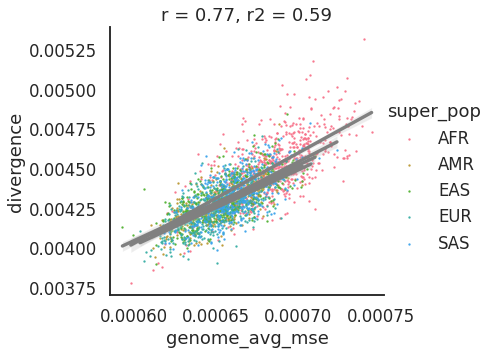

In [20]:
corr_plot(anc)

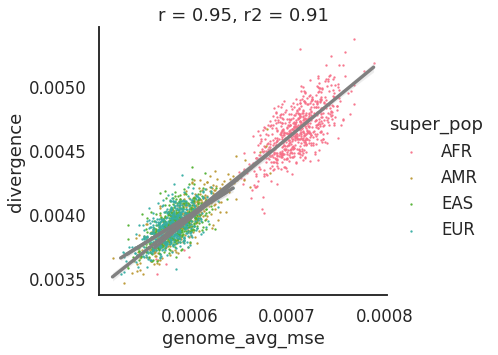

In [21]:
corr_plot(ref)

## Divergence

In [22]:
def plot_pop_divergence(df, ref):
    sup_order = df.groupby(by=["super_pop"])["divergence"].mean().sort_values().index
    sub_order = df.groupby(by=["sub_pop"])["divergence"].mean().sort_values().index
    
    sup_mapping = pd.DataFrame({
    'super': sup_order,
    })
    sup_mapping = sup_mapping.reset_index().set_index('super')

    sub_mapping = pd.DataFrame({
        'sub': sub_order,
    })
    sub_mapping = sub_mapping.reset_index().set_index('sub')
    
    df['super_rank'] = df['super_pop'].map(sup_mapping['index'])
    df['sub_rank'] = df['sub_pop'].map(sub_mapping['index'])
    
    my_order = df.sort_values(['super_rank','sub_rank'])
    
    my_order = my_order['sub_pop'].drop_duplicates().values
    
    amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
    eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
    afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
    sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
    eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
    
    if ref:
        my_pal = eur_pal + eas_pal + amr_pal + afr_pal
    else:
        my_pal = eur_pal + amr_pal + eas_pal + sas_pal + afr_pal
    sns.set(font_scale=4, context = 'poster', style='white')
    plt.figure(figsize=(100,30))
    sns.stripplot(x='sub_pop', y='divergence', data=df, dodge=False,s=20, 
                  palette=my_pal, 
                  order = my_order)
    plt.xlabel('\nPopulation', fontsize=100)
    plt.ylabel('Genome-Wide\n3D Divergence\n', fontsize=100)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=100)
    plt.tick_params(axis='both', which='major', labelsize=80)
    #plt.savefig('fig2.svg', format='svg')
    
    return

No handles with labels found to put in legend.


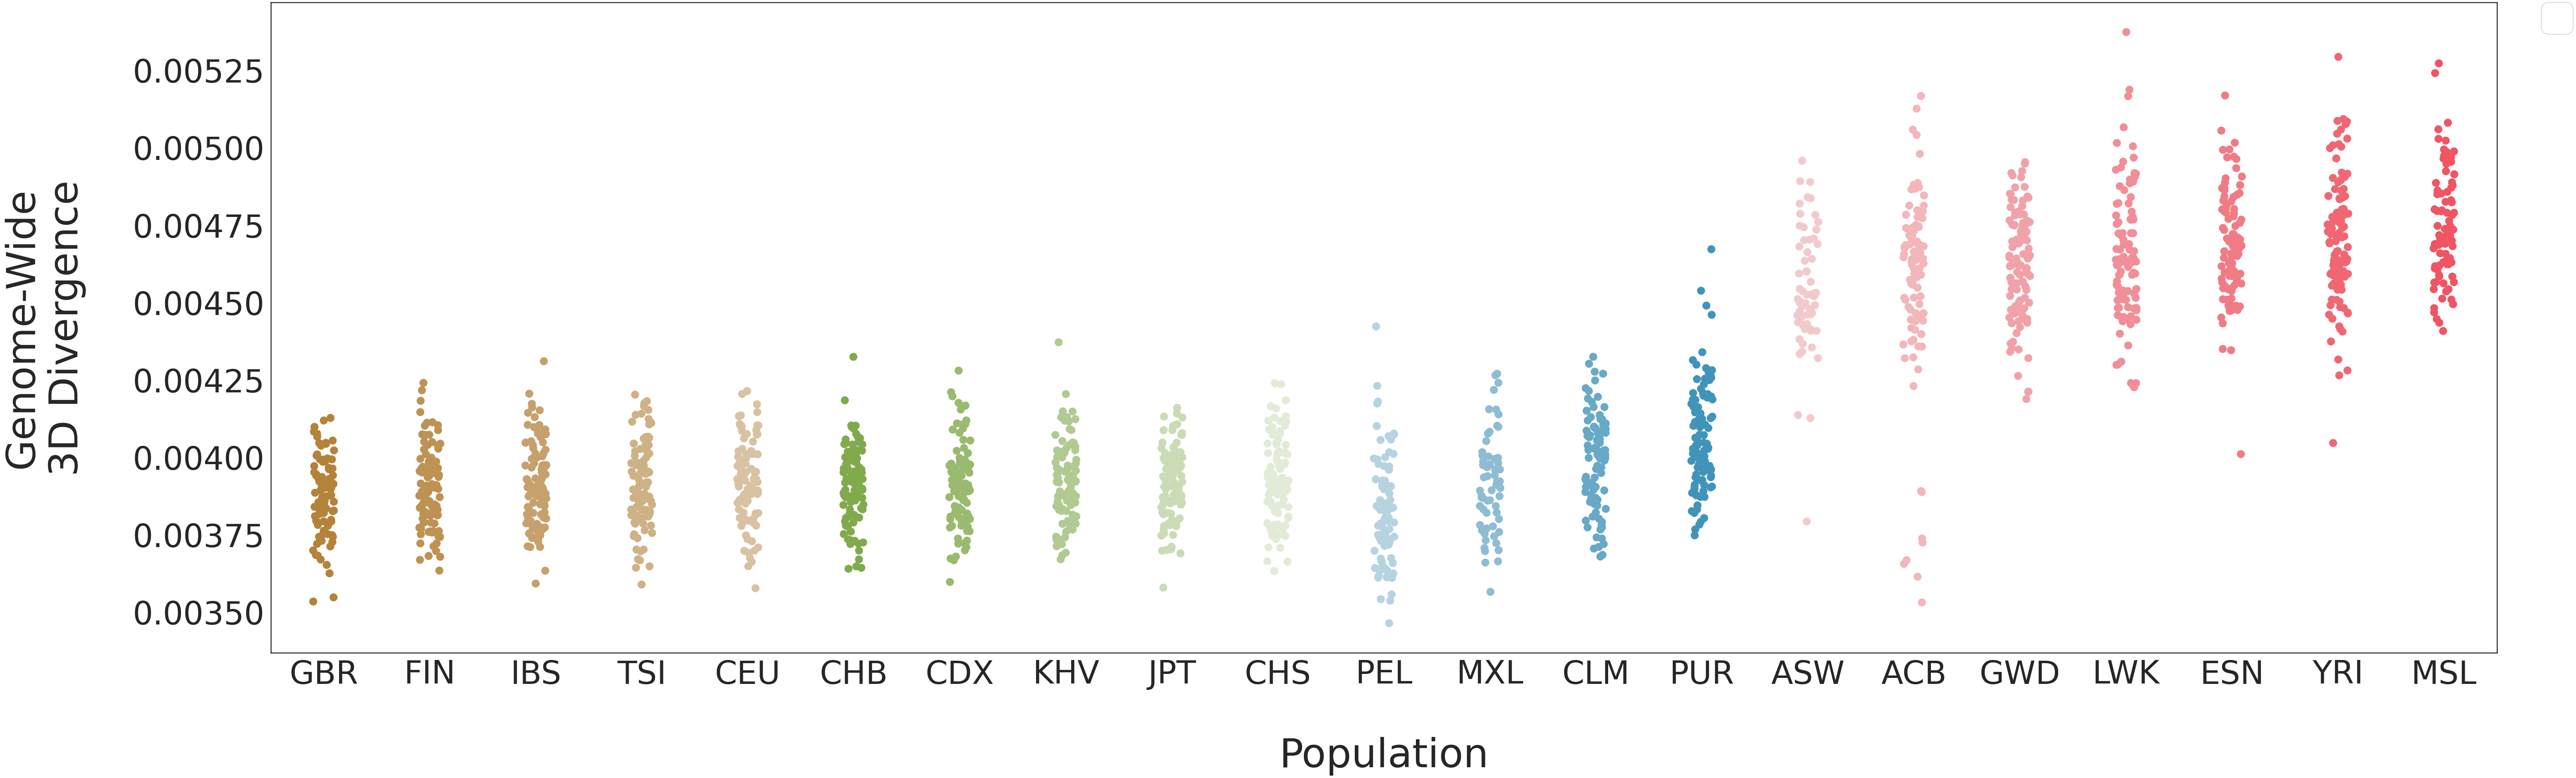

In [23]:
plot_pop_divergence(ref, True)

No handles with labels found to put in legend.


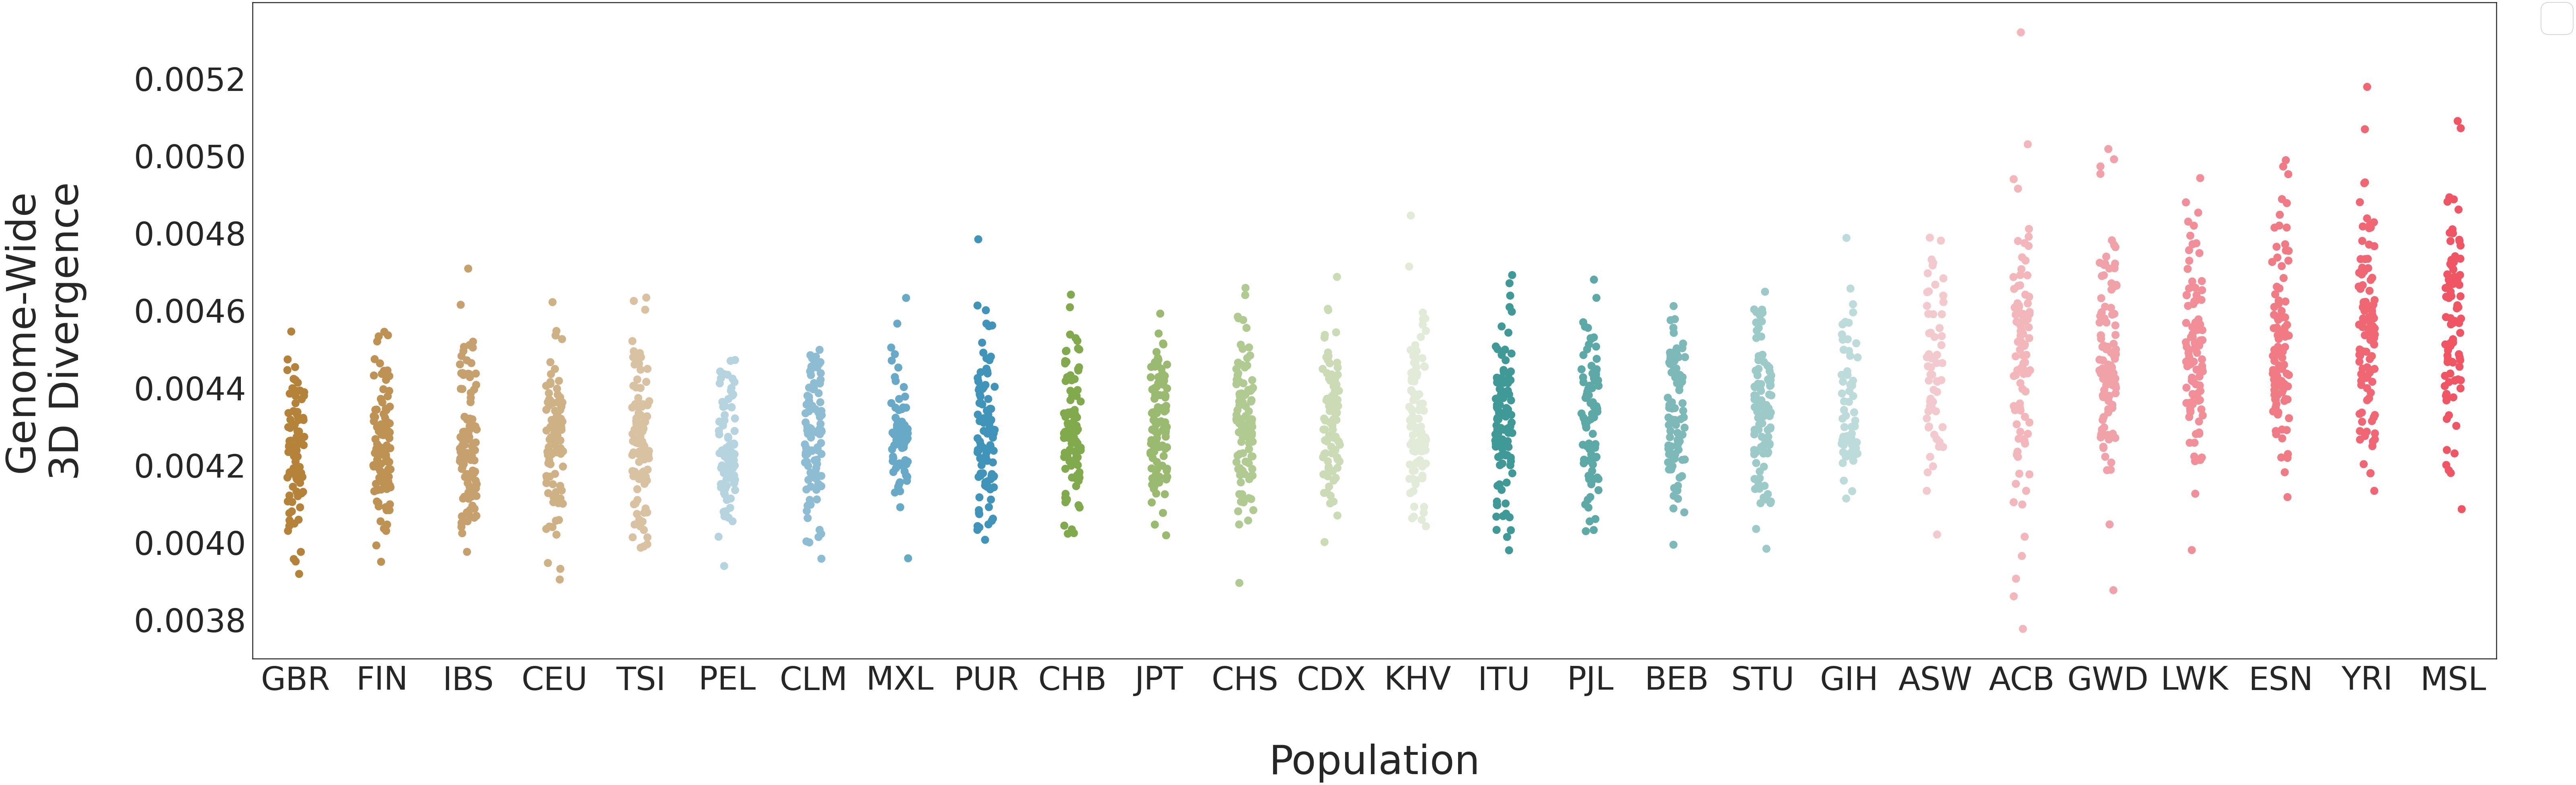

In [25]:
plot_pop_divergence(anc, False)

# Window wise metrics

### Distributions

In [26]:
sns.set(palette='husl', font_scale=1, context = 'poster', style='white')

In [27]:

anc_mse = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/anc_window_mse.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_spear = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/anc_window_spearman.csv'
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear

# ref_mse = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ref_window_mse.csv'
#                     , sep=',', header=[0,1,2,3], index_col=[0,1])
# ref_spear = pd.read_table('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/ref_window_spearman.csv'
#                     , sep=',', header=[0,1,2,3], index_col=[0,1])
# ref_div = 1-ref_spear

In [28]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

In [29]:
windows_to_keep = anc_div.index

In [30]:
windows_to_keep

MultiIndex([( 'chr1',  1048576),
            ( 'chr1',  1572864),
            ( 'chr1',  3145728),
            ( 'chr1',  3670016),
            ( 'chr1',  4194304),
            ( 'chr1',  4718592),
            ( 'chr1',  5242880),
            ( 'chr1',  5767168),
            ( 'chr1',  6291456),
            ( 'chr1',  6815744),
            ...
            ('chr22', 44040192),
            ('chr22', 44564480),
            ('chr22', 45088768),
            ('chr22', 45613056),
            ('chr22', 46137344),
            ('chr22', 46661632),
            ('chr22', 47185920),
            ('chr22', 47710208),
            ('chr22', 48234496),
            ('chr22', 48758784)],
           names=['chr', 'windowStartPos'], length=4873)

## HSMRCA

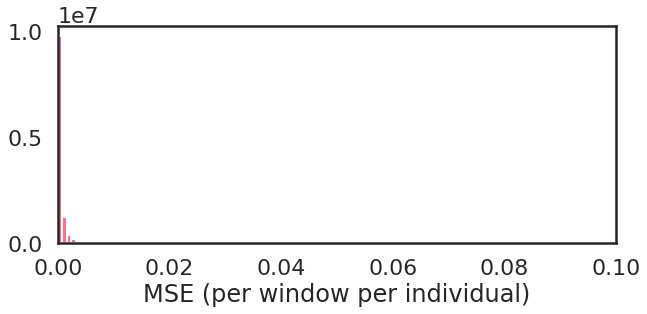

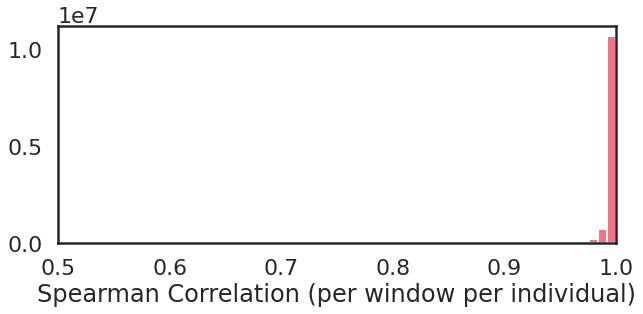

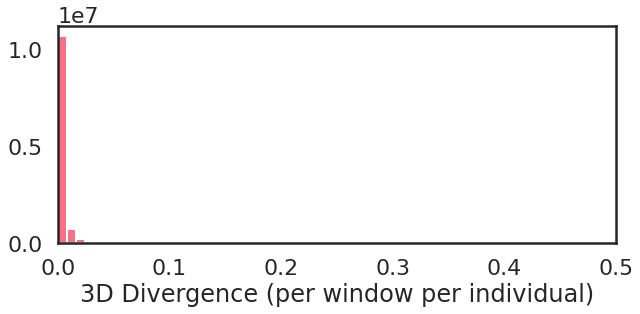

In [31]:
per_window_hists(anc_mse, anc_spear, anc_div)

Text(0.5, 0, '3D Divergence (per window per individual)')

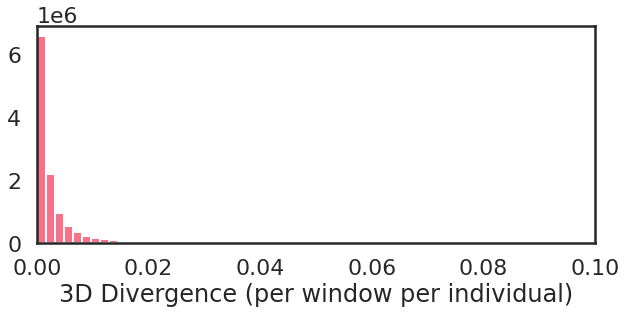

In [32]:
div_flat = anc_div.to_numpy().flatten()
plt.figure(figsize=(10,4))
plt.hist(div_flat, bins=500)
plt.xlim(0, .1)
plt.xlabel('3D Divergence (per window per individual)')

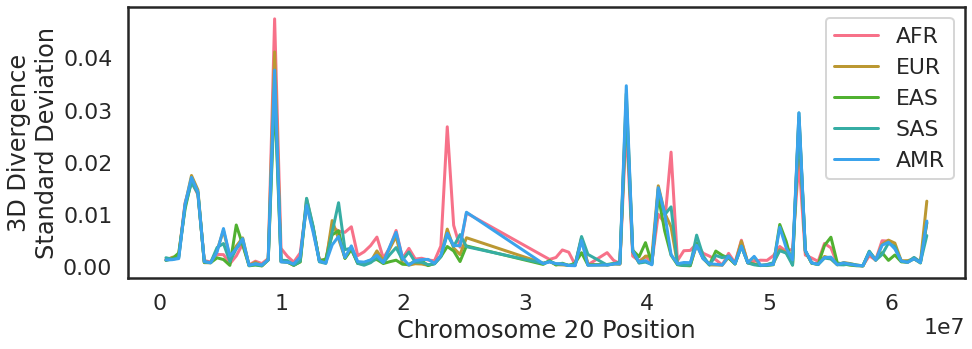

In [33]:
df = anc_div
chrm='chr20'

afr_avg = df['AFR'].std(axis=1)
amr_avg = df['AMR'].std(axis=1)
eur_avg = df['EUR'].std(axis=1)
eas_avg = df['EAS'].std(axis=1)
sas_avg = df['SAS'].std(axis=1)

windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
windows.columns = ['AFR','AMR','EUR','EAS','SAS']

windows['AVERAGE'] = windows.mean(axis=1)

df = windows.loc[chrm]

fig, ax = plt.subplots(figsize=[15,5])
sns.lineplot(y=df.AFR, 
             x=df.index, 
            label='AFR')
sns.lineplot(y=df.EUR, 
             x=df.index, 
            label='EUR')
sns.lineplot(y=df.EAS, 
             x=df.index, 
            label='EAS')
sns.lineplot(y=df.SAS, 
             x=df.index, 
            label='SAS')
sns.lineplot(y=df.AMR, 
             x=df.index, 
            label='AMR')



plt.ylabel('3D Divergence\nStandard Deviation')
plt.xlabel('Chromosome 20 Position')

plt.savefig('chr20std.svg', format='svg')

# Enrichment?

In [ ]:
genes = pybedtools.BedTool('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment_divergent_from_ancestral/data/grch38_gene_annotations.bed')

In [ ]:
mean_df = pd.DataFrame()
mean_df['AFR'] = anc_div['AFR'].mean(axis=1)
mean_df['AMR'] = anc_div['AMR'].mean(axis=1)
mean_df['EUR'] = anc_div['EUR'].mean(axis=1)
mean_df['EAS'] = anc_div['EAS'].mean(axis=1)
mean_df['SAS'] = anc_div['SAS'].mean(axis=1)
mean_df['All'] = anc_div.mean(axis=1)

In [ ]:
mean_df

In [ ]:
top_10 = mean_df[mean_df.All >= (mean_df.All.quantile(.9))]

In [ ]:
all_windows = pd.DataFrame(index=mean_df.index).reset_index()
all_windows.columns = ['chr','start']

In [ ]:
all_windows['end'] = all_windows['start'] + 2**20

In [ ]:
all_windows

In [ ]:
windows = pd.DataFrame(index=top_10.index).reset_index()
windows.columns = ['chr','start']

In [ ]:
all_bed = pybedtools.BedTool.from_dataframe(all_windows)

In [ ]:
all_bed.saveas('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment_divergent_from_ancestral//data/all_windows.bed')

In [ ]:
gene_df = genes.to_dataframe(disable_auto_names=True, header=None)

In [ ]:
gene_df

In [ ]:
windows

In [ ]:
windows['end'] = windows['start'] + 2**20

In [ ]:
windows['chr'] = windows['chr'].str.strip('chr')

In [ ]:
windows

In [ ]:
genes = pybedtools.BedTool('/wynton/group/capra/projects/archaic_splicing/data/annotations/grch38_gene_annotations.bed')

In [ ]:
window_bed = pybedtools.BedTool.from_dataframe(windows)

In [ ]:
window_bed.saveas('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment/data/diff_windows.bed')

In [ ]:
gene_overlap = window_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])

In [ ]:
gene_overlap.gene_name.unique().shape

In [ ]:
gene_overlap

In [ ]:
gene_map = gene_overlap.drop(columns=['gene_chr','gene_start','gene_end','overlap'])

In [ ]:
gene_map['chr'] = 'chr' + gene_map['window_chrm'].astype('str')

In [ ]:
gene_map = gene_map.drop(columns=['window_chrm'])

In [ ]:
a = gene_map['gene_name'].unique()

In [ ]:
pd.DataFrame(a).to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment/data/diff_window_genes_observed.txt', header=None, index=False)

In [ ]:
np.savetxt('diff_window_genes_observed.txt', a, delimiter='\n')

In [ ]:
gene_map.set_index(['chr','start'])

In [ ]:
pops_out[pops_out.AFR_out].index

In [ ]:
popsgene_map

In [ ]:
def get_gene():
    gene_list=[]
    


In [ ]:
all_windows = pd.DataFrame(index=pop_diffs.index).reset_index()
all_windows.columns = ['chr','start']

all_windows['end'] = all_windows['start'] + 2**20

all_windows



all_bed = pybedtools.BedTool.from_dataframe(all_windows)

all_bed.saveas('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment/data/all_windows.bed')

gene_df = genes.to_dataframe(disable_auto_names=True, header=None)

shuffled = all_windows.sample(n=windows.shape[0], random_state=1)
shuffled_bed = pybedtools.BedTool.from_dataframe(shuffled)

genes = pybedtools.BedTool('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment/data/grch38_gene_annotations.bed')





intersect = all_bed.intersect(shuffled_bed, wo = True).intersect(genes, loj = True).to_dataframe(disable_auto_names=True, header=None)

intersect










windows = pd.DataFrame(index=pops_out.index).reset_index()
windows.columns = ['chr','start']

windows

windows['end'] = windows['start'] + 2**20

windows['chr'] = windows['chr'].str.strip('chr')

windows

genes = pybedtools.BedTool('/wynton/group/capra/projects/archaic_splicing/data/annotations/grch38_gene_annotations.bed')

window_bed = pybedtools.BedTool.from_dataframe(windows)

window_bed.saveas('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment/data/diff_windows.bed')

gene_overlap = window_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])

gene_overlap.gene_name.unique().shape

gene_overlap

gene_map = gene_overlap.drop(columns=['gene_chr','gene_start','gene_end','overlap'])

gene_map['chr'] = 'chr' + gene_map['window_chrm'].astype('str')

gene_map = gene_map.drop(columns=['window_chrm'])

a = gene_map['gene_name'].unique()

pd.DataFrame(a).to_csv('/wynton/group/capra/projects/modern_human_3Dgenome/data/phenotype_enrichment/data/diff_window_genes_observed.txt', header=None, index=False)

np.savetxt('diff_window_genes_observed.txt', a, delimiter='\n')

gene_map.set_index(['chr','start'])

pops_out[pops_out.AFR_out].index

popsgene_map

def get_gene():
    gene_list=[]
    


# Sequence

In [34]:
list_file = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_hsmrca.txt")
base = 'hsmrca_ancestral'
COMP_PATH = os.path.join(DATA_PATH,"pairwise/sequence/1KGvsHSMRCA")

In [41]:
comp_list=pd.read_table(list_file, sep=' ', names=['1KG','ancestor'])
if base != 'hg38_reference':
    base_df = comp_list[comp_list.ancestor==base].set_index('1KG')
else:
    base_df = comp_list.set_index('1KG')

In [45]:
base_df = anc[['ancestor']]

In [46]:
comp_dict_seq = {}
print('first for')
for row in base_df.index:
    ind = str(base_df.loc[row].name)
    filename = 'SeqComps_%s_vs_%s.txt' % (ind,base)
    if os.path.exists('%s/%s' % (COMP_PATH,filename)):
        try:
            df = pd.read_table('%s/%s' % (COMP_PATH,filename))
            df = df[df.chrm != 'chrX']
            comp_dict_seq[ind] = df
        except:
            print('broken')
            continue     
print('done')

indivs = list(comp_dict_seq.keys())
### Window by window
seq_id = pd.DataFrame(index = windows_to_keep, columns = indivs)

### Genome wide averages        
base_df['seq_id']=''
print('second for')
for ind in comp_dict_seq.keys():
    df = comp_dict_seq[ind]
    df = df.set_index(['chrm','start_loc'])
    try:
        df = df.loc[windows_to_keep]
        avg_seq_id =float(np.mean(df['seqComp_raw'].astype('float')))

        base_df.seq_id.loc[ind]=avg_seq_id

        seq_id[ind]=df['seqComp_raw']
    except:
        print('missing data for individual: %s' % ind)
print('done')  



base_df['temp'] = base_df.index
new = base_df.temp.str.split("_", expand = True)
base_df['super_pop'] = new[0]
base_df['sub_pop'] = new[1]
base_df['sex'] = new[2]
base_df['id'] = new[3]

genome_wide = base_df.drop(columns=['temp'])
genome_wide = genome_wide[genome_wide.seq_id != '']
genome_wide.seq_id = genome_wide.seq_id.astype('float')

seq_id.columns = seq_id.columns.str.split('_', expand=True)


first for
done


/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


second for
missing data for individual: SAS_ITU_male_HG04060
done


/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [56]:
seq_id.drop('HG04060', axis=1, level=3)

AFR                       \
                                      ACB                        
                                   female                        
                                  HG01880              HG01883   
chr   windowStartPos                                             
chr1  1048576          0.9979305267333984   0.9978570938110352   
      1572864          0.9981098175048828   0.9981231689453125   
      3145728          0.9977731704711914   0.9976263046264648   
      3670016          0.9976110458374023   0.9975862503051758   
      4194304          0.9978618621826172   0.9978570938110352   
...                                   ...                  ...   
chr22 46661632         0.2507133483886719   0.2507467269897461   
      47185920        0.25144004821777344   0.2514495849609375   
      47710208         0.2500791549682617  0.25009822845458984   
      48234496        0.24960899353027344  0.24959278106689453   
      48758784        0.24944496154785156   0.2494029998779297   

                                                                \
                                                                 
                                                                 
                                  HG01886              HG01889   
chr   windowStartPos                                             
chr1  1048576          0.9977359771728516   0.9979715347290039   
      1572864          0.9981508255004883   0.9981918334960938   
      3145728          0.9977016448974609   0.9976177215576172   
      3670016          0.9976291656494141    0.997523307800293   
      4194304          0.9978761672973633   0.9978227615356445   
...                                   ...                  ...   
chr22 46661632        0.25069236755371094   0.2507143020629883   
      47185920        0.25142383575439453   0.2514476776123047   
      47710208         0.2500782012939453  0.25006866455078125   
      48234496        0.24956417083740234  0.24955177307128906   
      48758784         0.2494029998779297  0.24944591522216797   

                                                                \
                                                                 
                                                                 
                                  HG01894              HG01896   
chr   windowStartPos                                             
chr1  1048576          0.9978532791137695       0.997802734375   
      1572864          0.9982404708862305   0.9981498718261719   
      3145728          0.9975986480712891   0.9976940155029297   
      3670016          0.9975414276123047   0.9976577758789062   
      4194304          0.9978246688842773   0.9979496002197266   
...                                   ...                  ...   
chr22 46661632         0.2507133483886719   0.2506904602050781   
      47185920        0.25144100189208984  0.25144100189208984   
      47710208         0.2500734329223633   0.2500934600830078   
      48234496        0.24956703186035156  0.24957656860351562   
      48758784        0.24940967559814453  0.24944305419921875   

                                                                \
                                                                 
                                                                 
                                  HG01915              HG01956   
chr   windowStartPos                                             
chr1  1048576          0.9978008270263672   0.9978761672973633   
      1572864          0.9981393814086914   0.9981327056884766   
      3145728          0.9976234436035156   0.9976358413696289   
      3670016          0.9975852966308594   0.9974651336669922   
      4194304           0.997828483581543   0.9978771209716797   
...                                   ...                  ...   
chr22 46661632         0.2507495880126953   0.2507467269897461   
      47185920         0.2514467239379883   0.2514228820800781   
      477

In [53]:
df = genome_wide

In [57]:
df['seq_diff'] = 1-df['seq_id']

KeyError: 'seq_id'

No handles with labels found to put in legend.


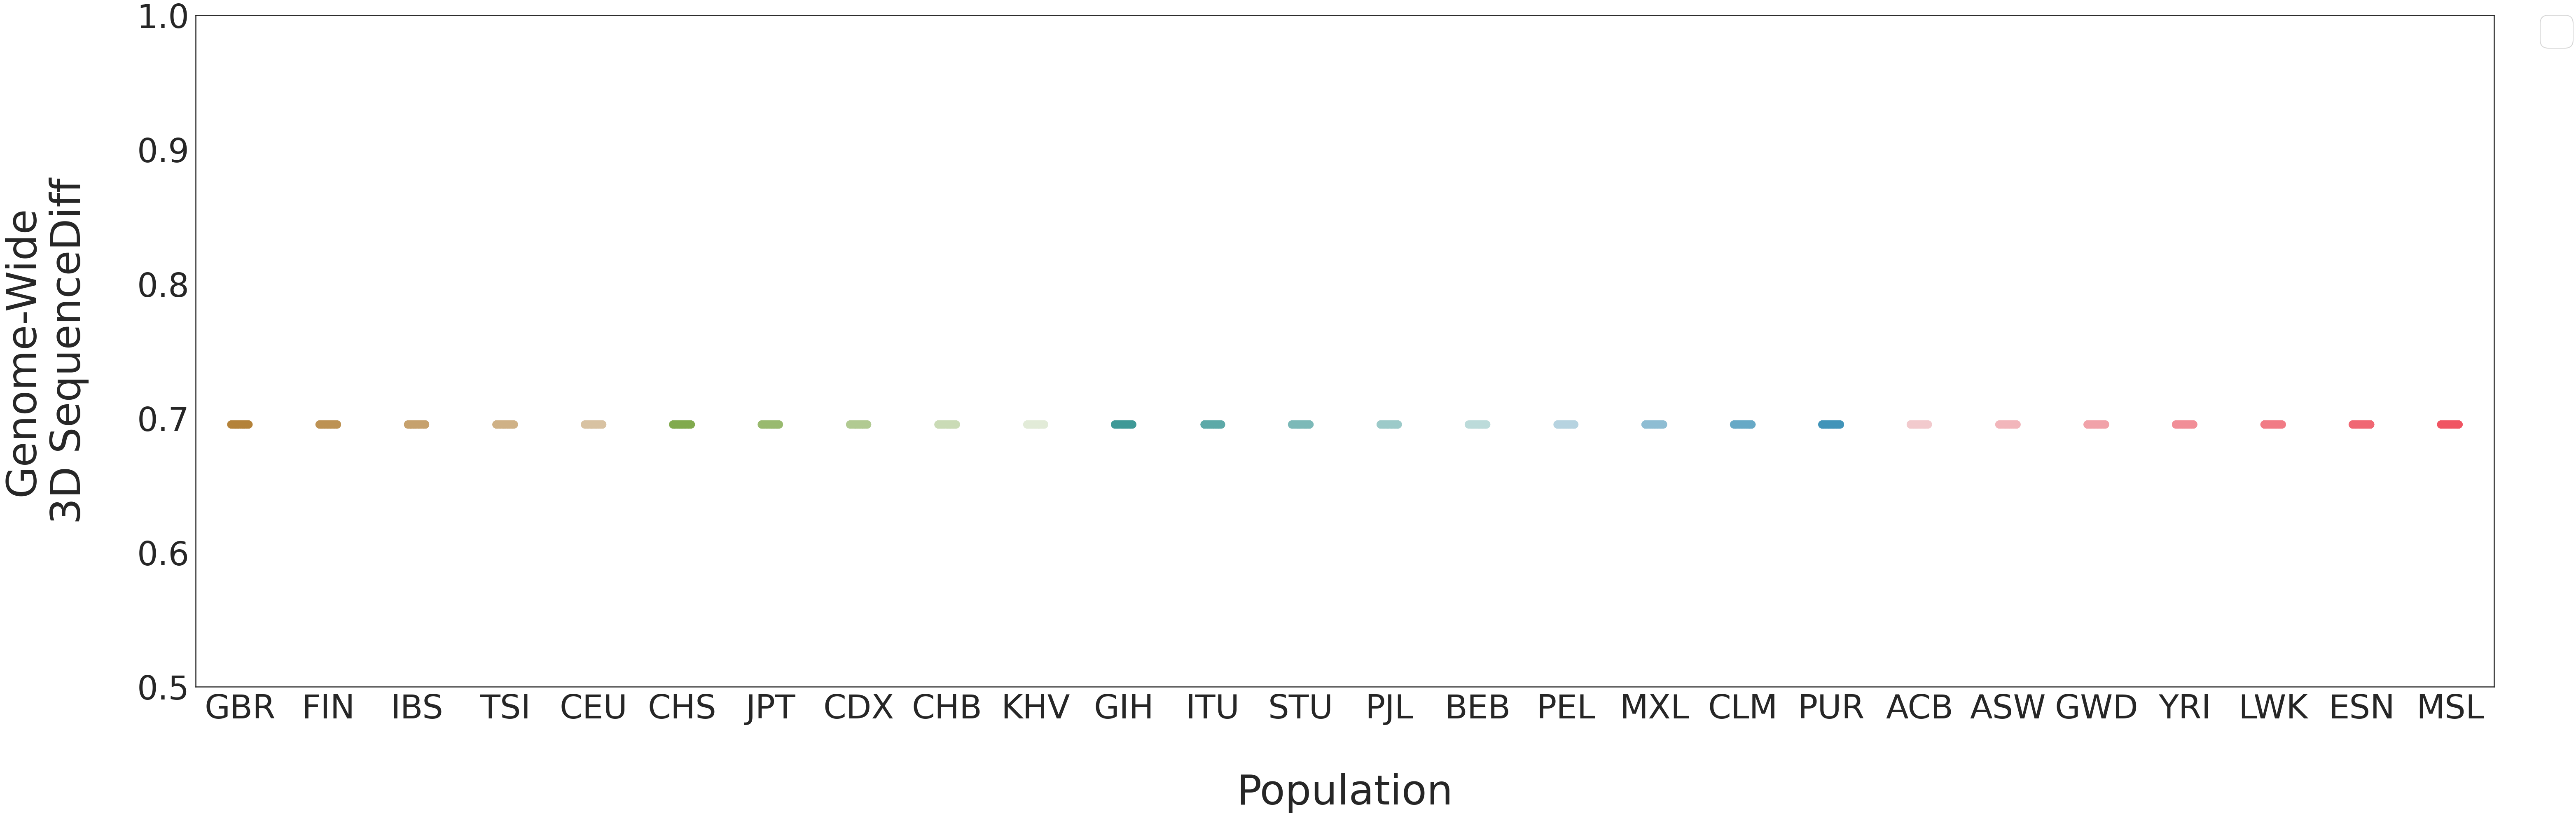

In [100]:
df = genome_wide
sup_order = df.groupby(by=["super_pop"])["seq_diff"].mean().sort_values().index
sub_order = df.groupby(by=["sub_pop"])["seq_diff"].mean().sort_values().index

sup_mapping = pd.DataFrame({
'super': sup_order,
})
sup_mapping = sup_mapping.reset_index().set_index('super')

sub_mapping = pd.DataFrame({
    'sub': sub_order,
})
sub_mapping = sub_mapping.reset_index().set_index('sub')

df['super_rank'] = df['super_pop'].map(sup_mapping['index'])
df['sub_rank'] = df['sub_pop'].map(sub_mapping['index'])

my_order = df.sort_values(['super_rank','sub_rank'])

my_order = my_order['sub_pop'].drop_duplicates().values

amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]

#my_pal = eur_pal + amr_pal + eas_pal + sas_pal + afr_pal
my_pal = eur_pal + eas_pal + sas_pal + amr_pal + afr_pal

sns.set(font_scale=4, context = 'poster', style='white')
plt.figure(figsize=(100,30))
sns.stripplot(x='sub_pop', y='seq_diff', data=df, dodge=False,s=20, 
                palette=my_pal, 
                order = my_order)
plt.ylim(0.5,1)
plt.xlabel('\nPopulation', fontsize=100)
plt.ylabel('Genome-Wide\n3D SequenceDiff\n', fontsize=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=100)
plt.tick_params(axis='both', which='major', labelsize=80)
# #plt.savefig('fig2.svg', format='svg')


In [97]:
genome_wide

,ancestor,seq_id,super_pop,sub_pop,sex,id,super_rank,sub_rank,seq_diff
1KG,,,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.304678,AFR,ACB,female,HG01880,4,19,0.695322
AFR_ACB_female_HG01883,hsmrca_ancestral,0.304676,AFR,ACB,female,HG01883,4,19,0.695324
AFR_ACB_female_HG01886,hsmrca_ancestral,0.304674,AFR,ACB,female,HG01886,4,19,0.695326
AFR_ACB_female_HG01889,hsmrca_ancestral,0.304674,AFR,ACB,female,HG01889,4,19,0.695326
AFR_ACB_female_HG01894,hsmrca_ancestral,0.304677,AFR,ACB,female,HG01894,4,19,0.695323
...,...,...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.304682,SAS,STU,male,HG04039,2,13,0.695318
SAS_STU_male_HG04100,hsmrca_ancestral,0.304682,SAS,STU,male,HG04100,2,13,0.695318
SAS_STU_male_HG04107,hsmrca_ancestral,0.304683,SAS,STU,male,HG04107,2,13,0.695317


In [72]:
seq_id.loc['chr9']

AFR                                            \
                                ACB                                             
                             female                                             
                            HG01880              HG01883              HG01886   
windowStartPos                                                                  
524288           0.2329397201538086  0.23291873931884766  0.23293590545654297   
1048576         0.24278736114501953  0.24277400970458984  0.24277019500732422   
1572864         0.24332904815673828  0.24332046508789062  0.24331951141357422   
2097152         0.23058032989501953   0.2305612564086914  0.23058605194091797   
2621440         0.22968482971191406   0.2296590805053711  0.22967910766601562   
...                             ...                  ...                  ...   
134742016                       0.0                  0.0                  0.0   
135266304                       0.0                  0.0                  0.0   
135790592                       0.0                  0.0                  0.0   
136314880                       0.0                  0.0                  0.0   
136839168                       0.0                  0.0                  0.0   

                                                                               \
                                                                                
                                                                                
                            HG01889              HG01894              HG01896   
windowStartPos                                                                  
524288            0.232940673828125  0.23296833038330078   0.2329540252685547   
1048576         0.24272727966308594  0.24279117584228516  0.24277591705322266   
1572864         0.24329853057861328  0.24332523345947266  0.24330520629882812   
2097152          0.2306060791015625  0.23056888580322266      0.2305908203125   
2621440         0.22969818115234375   0.2296915054321289   0.2296743392944336   
...                             ...                  ...                  ...   
134742016                       0.0                  0.0                  0.0   
135266304                       0.0                  0.0                  0.0   
135790592                       0.0                  0.0                  0.0   
136314880                       0.0                  0.0                  0.0   
136839168                       0.0                  0.0                  0.0   

                                                                               \
                                                                                
                                                                                
                            HG01915              HG01956              HG01958   
windowStartPos                                                                  
524288          0.23293590545654297  0.23293495178222656   0.2329111099243164   
1048576         0.24274921417236328  0.24277496337890625   0.2427377700805664   
1572864         0.24331951141357422  0.24332332611083984   0.2433452606201172   
2097152         0.23059368133544922  0.23054790496826172  0.23061561584472656   
2621440           0.229644775390625   0.2296772003173828   0.2297039031982422   
...                             ...                  ...                  ...   
134742016                       0.0                  0.0                  0.0   
135266304                       0.0                  0.0                  0.0   
135790592                       0.0                  0.0                  0.0   
136314880                       0.0                  0.0                  0.0   
136839168                       0.0                  0.0                  0.0   

                                     ...                  SAS  \
                                     ...                  STU   
           

In [ ]:
seq_id.mean(axis=1)

chr    windowStartPos
chr1   1048576          NaN
       1572864          NaN
       3145728          NaN
       3670016          NaN
       4194304          NaN
                         ..
chr22  46661632         NaN
       47185920         NaN
       47710208         NaN
       48234496         NaN
       48758784         NaN
Length: 4873, dtype: float64

In [ ]:
seq_id

NameError: name 'seq_id' is not defined